In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


UsageError: Line magic function `%` not found.


## Classification Example - MNIST

In [3]:
mnist = tf.keras.datasets.mnist

In [4]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# rescale the images from [0, 255] to the [0.0, 0.1] range
x_train, x_test = x_train / 255.0, x_test / 255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [ ]:
# check the first 10 examples

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
#     plt.xlabel(class_names[train_labels[i][0]])
plt.show()

# Modeling

The first layer in this network, tf.keras.layers.Flatten, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

training_history = model.fit(x_train, 
                             y_train, 
                             epochs=5,
                            validation_split=0.2)

In [ ]:
model.summary()

In [ ]:
# Evaluate returns the loss value and metrics values for the model.
model.evaluate(x_test, y_test)

Metrics like f1 score have been removed from Keras core. You need to calculate them manually. They removed them on 2.0 version. Those metrics are all global metrics, but Keras works in batches. 

In [17]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

In [ ]:
# summarize history for accuracy
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# CNN

In [5]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# rescale the images from [0, 255] to the [0.0, 0.1] range
x_train, x_test = x_train / 255.0, x_test / 255.0

In [7]:
# reshape dataset to have a single channel
x_train_reshaped = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test_reshaped = x_test.reshape((x_test.shape[0], 28, 28, 1))

In [8]:
x_train_reshaped.shape, x_train.shape

((60000, 28, 28, 1), (60000, 28, 28))

In [9]:
from tensorflow.keras.utils import to_categorical

# one hot encode target values
y_train_encoded = to_categorical(y_train, 10)
y_test_encoded = to_categorical(y_test, 10)

In [56]:
# Create the convolutional base

# extra convolutional layer
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, Flatten, Dense


model_cnn = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), 
           activation='relu', 
           input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')    
])

model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                51264     
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

The output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

To complete our model, we need to feed the last output tensor from the convolutional base (of shape (11, 11, 64)) into one or more Dense layers to perform classification.
Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor.

In [14]:
# Compile and train the model
model_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_cnn = model_cnn.fit(x=x_train_reshaped, 
                             y=y_train_encoded, 
                             epochs=5,
                             validation_split=0.2)

Epoch 1/5
1500/1500 [==============================] - 50s 33ms/step - loss: 0.1934 - accuracy: 0.9404 - val_loss: 0.0698 - val_accuracy: 0.9798
Epoch 2/5
1500/1500 [==============================] - 44s 29ms/step - loss: 0.0601 - accuracy: 0.9817 - val_loss: 0.0648 - val_accuracy: 0.9802
Epoch 3/5
1500/1500 [==============================] - 52s 35ms/step - loss: 0.0424 - accuracy: 0.9866 - val_loss: 0.0524 - val_accuracy: 0.9855
Epoch 4/5
1500/1500 [==============================] - 52s 35ms/step - loss: 0.0336 - accuracy: 0.9887 - val_loss: 0.0378 - val_accuracy: 0.9892
Epoch 5/5
1500/1500 [==============================] - 59s 40ms/step - loss: 0.0250 - accuracy: 0.9915 - val_loss: 0.0404 - val_accuracy: 0.9893


In [15]:
# Evaluate returns the loss value and metrics values for the model.
model_cnn.evaluate(x_test_reshaped, y_test_encoded)

313/313 [==============================] - 4s 12ms/step - loss: 0.0291 - accuracy: 0.9898


[0.02908739261329174, 0.989799976348877]

In [18]:
y_pred_cnn = model_cnn.predict(x_test_reshaped, batch_size=64, 
                               verbose=1)
y_pred_bool_cnn = np.argmax(y_pred_cnn, axis=1)

print(classification_report(y_test, y_pred_bool_cnn))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.98      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.98      0.98       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



(0.9, 1.0)

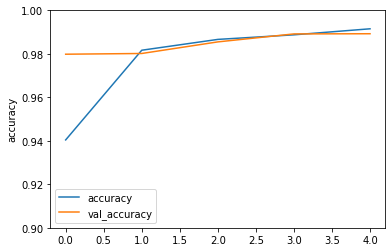

In [22]:
# summarize history for accuracy
df_result = pd.DataFrame(history_cnn.history)
df_result[['accuracy', 'val_accuracy']].plot()
plt.ylabel("accuracy")
plt.ylim(.9, 1)

(0.0, 0.2)

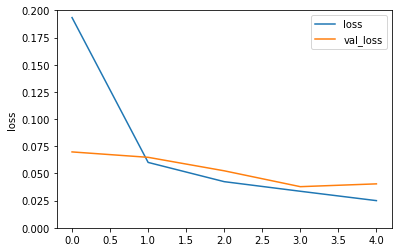

In [24]:
# summarize history for loss
df_result[['loss', 'val_loss']].plot()
plt.ylabel("loss")
plt.ylim(0, 0.2)

### visualize layers

In [26]:
layer1 = model_cnn.layers[0]

In [28]:
weights, biases = layer1.get_weights()

In [29]:
weights.shape

(3, 3, 1, 32)

Using a filter smaller than the input is intentional as it allows the same filter (set of weights) to be multiplied by the input array multiple times at different points on the input. Specifically, the filter is applied systematically to each overlapping part or filter-sized patch of the input data, left to right, top to bottom.

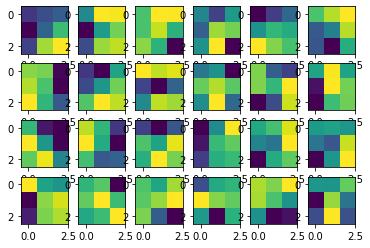

In [30]:
fig, axes = plt.subplots(4, 6)
for ax, weight in zip(axes.ravel(), weights.T):
    ax.imshow(weight[0, :, :])

In [39]:
from tensorflow.keras import backend as K

# with a Sequential model
get_1rd_layer_output = K.function([model_cnn.layers[0].input],
                                  [model_cnn.layers[0].output])
get_3rd_layer_output = K.function([model_cnn.layers[0].input],
                                  [model_cnn.layers[3].output])

layer1_output = get_1rd_layer_output([x_train_reshaped[:5]])[0]
layer3_output = get_3rd_layer_output([x_train_reshaped[:5]])[0]

In [48]:
layer1_output.shape

(5, 26, 26, 32)

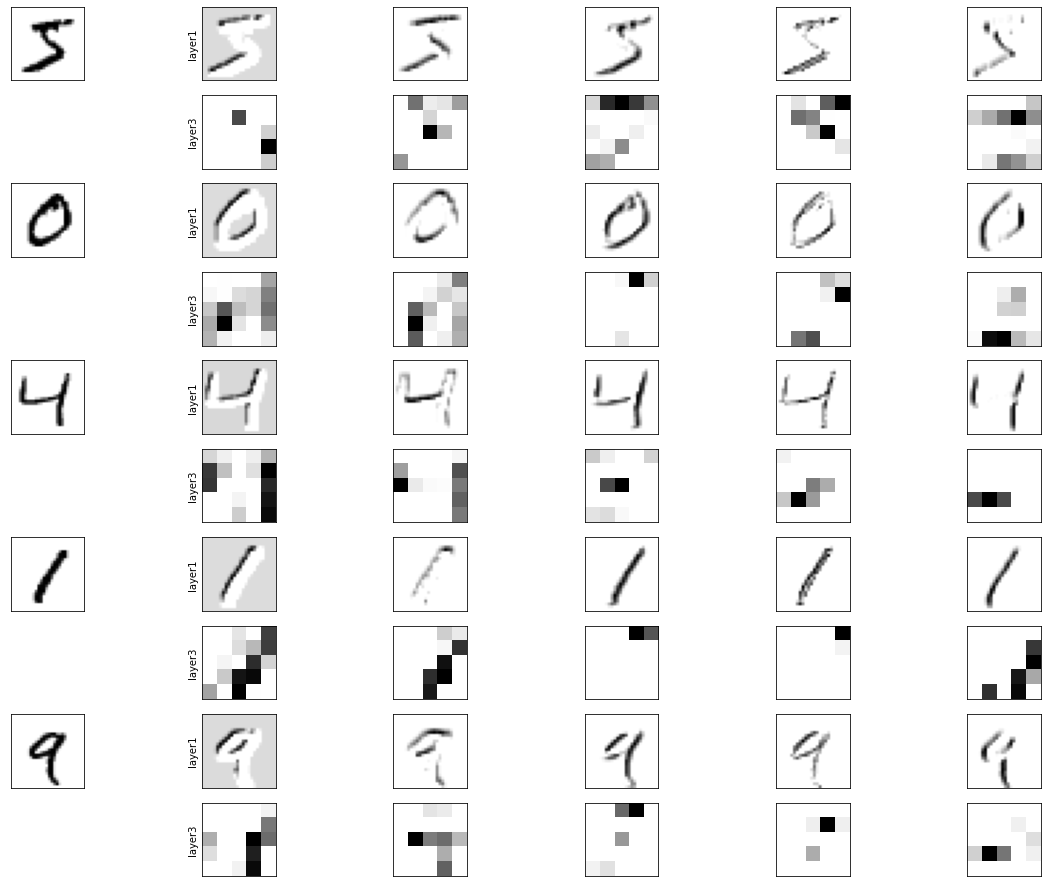

In [53]:
weights, biases = model_cnn.layers[0].get_weights()
n_images = layer1_output.shape[0]
# n_filters = layer1_output.shape[3]
n_filters = 5



fig, axes = plt.subplots(n_images * 2, n_filters + 1, figsize=(20, 16), subplot_kw={'xticks': (), 'yticks': ()})
for i in range(n_images):
    # for reach input image (= 2 rows)
    axes[2 * i, 0].imshow(x_train_reshaped[i, :, :, 0], cmap="gray_r")
    axes[2 * i + 1, 0].set_visible(False)
    axes[2 * i, 1].set_ylabel("layer1")
    axes[2 * i + 1, 1].set_ylabel("layer3")
    for j in range(n_filters):
        # for each feature map (same number in layer 1 and 3)
        axes[2 * i, j + 1].imshow(layer1_output[i, :, :, j], cmap='gray_r')
        axes[2 * i + 1, j + 1].imshow(layer3_output[i, :, :, j], cmap='gray_r')

# Batch Normalization

In [55]:
# Create the convolutional base

# extra convolutional layer
from tensorflow.keras.layers import  BatchNormalization


model_cnn_bn = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), 
           activation='relu', 
           input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')    
])

model_cnn_bn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 11, 11, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 800)              

In [58]:
# Compile and train the model
model_cnn_bn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_cnn_bn = model_cnn_bn.fit(x=x_train_reshaped, 
                             y=y_train_encoded, 
                             epochs=5,
                             validation_split=0.2)

Epoch 1/5
1500/1500 [==============================] - 92s 61ms/step - loss: 0.1342 - accuracy: 0.9581 - val_loss: 0.0614 - val_accuracy: 0.9813
Epoch 2/5
1500/1500 [==============================] - 96s 64ms/step - loss: 0.0480 - accuracy: 0.9846 - val_loss: 0.0501 - val_accuracy: 0.9858
Epoch 3/5
1500/1500 [==============================] - 99s 66ms/step - loss: 0.0313 - accuracy: 0.9902 - val_loss: 0.0479 - val_accuracy: 0.9852
Epoch 4/5
1500/1500 [==============================] - 67s 45ms/step - loss: 0.0258 - accuracy: 0.9917 - val_loss: 0.0414 - val_accuracy: 0.9898
Epoch 5/5
1500/1500 [==============================] - 57s 38ms/step - loss: 0.0224 - accuracy: 0.9931 - val_loss: 0.0428 - val_accuracy: 0.9887


In [59]:
model_cnn_bn.evaluate(x_test_reshaped, y_test_encoded)

313/313 [==============================] - 3s 9ms/step - loss: 0.0340 - accuracy: 0.9904


[0.03397195041179657, 0.9904000163078308]

In [60]:
y_pred_cnn_bn = model_cnn_bn.predict(x_test_reshaped, batch_size=64, 
                               verbose=1)
y_pred_bool_cnn_bn = np.argmax(y_pred_cnn_bn, axis=1)

print(classification_report(y_test, y_pred_bool_cnn_bn))

157/157 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.98      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



(0.9, 1.0)

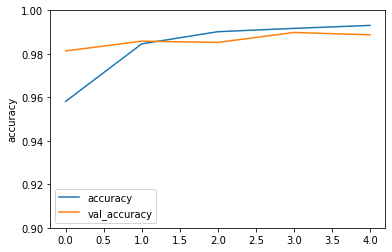

In [61]:
# summarize history for accuracy
df_result = pd.DataFrame(history_cnn_bn.history)
df_result[['accuracy', 'val_accuracy']].plot()
plt.ylabel("accuracy")
plt.ylim(.9, 1)

In [ ]:
# Transfer learning with CNN